In [1]:
import importlib, os, gc, sys

import SXBQ as sx

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt
import math


import glidertools as gt
import matplotlib.cm as cm
import matplotlib.colors as cl
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec


import seaborn as sns
sns.set(
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'k',
            
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=2)


import warnings
warnings.filterwarnings('ignore')


# Define the value ranges and corresponding colors
ranges = [-180, -90, -45, 45, 90, 180]
colors = ["#d5d9cd","#884da8","#b8ce69","#a0d9d9","#d5d9cd"] #
# Create a colormap based on the ranges and colors
cma = ListedColormap(colors)
norm = cl.BoundaryNorm(ranges, len(colors))

# Letters for plots
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
# letters = ['a1','a2','a3','a4','a5','b1','b2','b3','b4','b5','c1','c2','c3','c4','c5','d1','d2','d3','d4','d5','u','v','w','x','y','z']
alp=1

## Import data

In [3]:
#Import data:
ds= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/final/gridded_SEA057.nc') ## sections 
df=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/final/SEA057.nc')  ## timsereies

## Derived variables - MLD, Sh, Tu, Ri, N2

In [5]:
XX, YY =np.meshgrid(ds.x, ds.y)

def MLD_(df):
    XX, YY=np.meshgrid(df.x, df.y)
    mld_=[]
    for ii in range(len(df.trans_num)):
        mld_.append(gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), df.potential_density[ii].values.flatten(),
                                                 thresh=0.125, ref_depth=2, return_as_mask=False))
    return mld_

ds['mld']=(('trans_num', 'x'), np.array(MLD_(ds)))

Tu=[]
for i in range(70):
    tu_sec=np.append(gsw.Turner_Rsubrho(ds.abs_salinity[i], ds.cons_temp[i],YY)[0], np.nan*np.zeros((1,90)), axis=0)
    Tu.append(tu_sec)
    
Rro=[]
for i in range(70):
    tu_sec=np.append(gsw.Turner_Rsubrho(ds.abs_salinity[i], ds.cons_temp[i],YY)[1], np.nan*np.zeros((1,90)), axis=0)
    Rro.append(tu_sec)
    
N22=[]
for i in range(70):
    N22_sec=np.append(gsw.Nsquared(ds.abs_salinity[i], ds.cons_temp[i],YY)[0], np.nan*np.zeros((1,90)), axis=0)
    N22.append(N22_sec)
    
Val, Vac=[], []
for i in tqdm(range(70)):
    vacr= ds.V_across_detided[i].to_pandas().rolling(20, center=True).mean().rolling(3, center=True, axis=1).mean().to_numpy()
    val= ds.V_along_detided[i].to_pandas().rolling(20, center=True).mean().rolling(3, center=True, axis=1).mean().to_numpy()
    Val.append(val)
    Vac.append(vacr)

ds['V_along_roll']=(('trans_num', 'y', 'x'), Val)
ds['V_across_roll']=(('trans_num', 'y', 'x'), Vac)

V_across_z=ds.V_across_roll.diff(dim='y')/2
V_along_z=ds.V_along_roll.diff(dim='y')/2

S=V_across_z**2+V_along_z**2

Sh_=[]
for i in range(70):
    Sh_lol=np.append(S[i], np.nan*np.zeros((1,90)), axis=0)
    Sh_.append(Sh_lol)
    
    
ds['Tu']=(('trans_num', 'y', 'x'), Tu)
ds['R_ro']=(('trans_num', 'y', 'x'), Rro)
ds['Sh']=(('trans_num', 'y', 'x'), Sh_)
ds['N2']=(('trans_num', 'y', 'x'), N22)
ds['Ri-1']=ds['Sh']/ds['N2']
ds['O2_Ri']=(np.abs(ds.oxygen_concentration.diff(dim='y')/2))*ds['Ri-1']

  0%|          | 0/70 [00:00<?, ?it/s]

## Plotting functions

In [6]:
## for plotting sections
daxis=np.arange(-10,80,1)
yaxis=np.arange(0,1000,2)
LW=2
## for plotting profiles

def plot_profiles(ax, trannum, profnum):  ##trannum  N+1, profnum= [28, 16, 32, 16]
    prf=np.unique(df.profile_num[df.transect_num==trannum].values)
    i=profnum
    dist=df.distance[df.profile_num==prf[i]].values[0]
    print(dist)
    ax.plot(df.abs_salinity[df.profile_num==prf[i]].values, df.pressure[df.profile_num==prf[i]].values, c='r', lw=LW)
    ax.set_xlim(35.5,39)
    axi=ax.twiny()
    axi.plot(df.cons_temp[df.profile_num==prf[i]].values, df.pressure[df.profile_num==prf[i]].values, lw=LW)
    axi.set_ylim(600,0)
    axi.set_xlim(10,30)
    return ax, axi
    
def dist_num_prof(trannum, profnum):  ##trannum  N+1, profnum= [28, ]
    prf=np.unique(df.profile_num[df.transect_num==trannum].values)
    dist=df.distance[df.profile_num==prf[profnum]].values[0]
    return dist, prf[profnum]

def plot_profiles_oxy(ax, trannum, profnum):  ##trannum  N+1, profnum= [28, 16, 32, 16]
    prf=np.unique(df.profile_num[df.transect_num==trannum].values)
    i=profnum
    dist=df.distance[df.profile_num==prf[i]].values[0]
    print(dist)
    ax.plot(df.abs_salinity[df.profile_num==prf[i]].values, df.pressure[df.profile_num==prf[i]].values, c='r', lw=LW)
    ax.set_xlim(35.5,39)
    axi=ax.twiny()
    axi.plot(df.cons_temp[df.profile_num==prf[i]].values, df.pressure[df.profile_num==prf[i]].values, lw=LW)
    axi.set_ylim(600,0)
    axi.set_xlim(10,30)
    axii=axi.twiny()
    axii.plot(pd.DataFrame(df.oxygen_concentration[df.profile_num==prf[i]].values).interpolate()[0].to_numpy(), df.pressure[df.profile_num==prf[i]].values, c='k', lw=LW)
    axii.set_ylim(600,0)
    axii.set_xlim(0, 240)
    return ax, axi, axii

ranges = [-180, -90, -45, 45, 90, 180]
# colortus = ["#d5d9cd","#884da8","#b8ce69","#a0d9d9","#d5d9cd"] #
colortus = ["beige","#884da8","#b8ce69","#a0d9d9","beige"] #
cma = ListedColormap(colortus)
norm = cl.BoundaryNorm(ranges, len(colortus))
cma

T# 39
P# 1734
03 Mar 2022
T# 32
P# 1418
09 Feb 2022
T# 56
P# 2588
15 Aug 2022
T# 70
P# 3444
12 Oct 2022
9.972162576555984
32.52854115342046
29.150937349464733
23.98405161688829
23.98405161688829


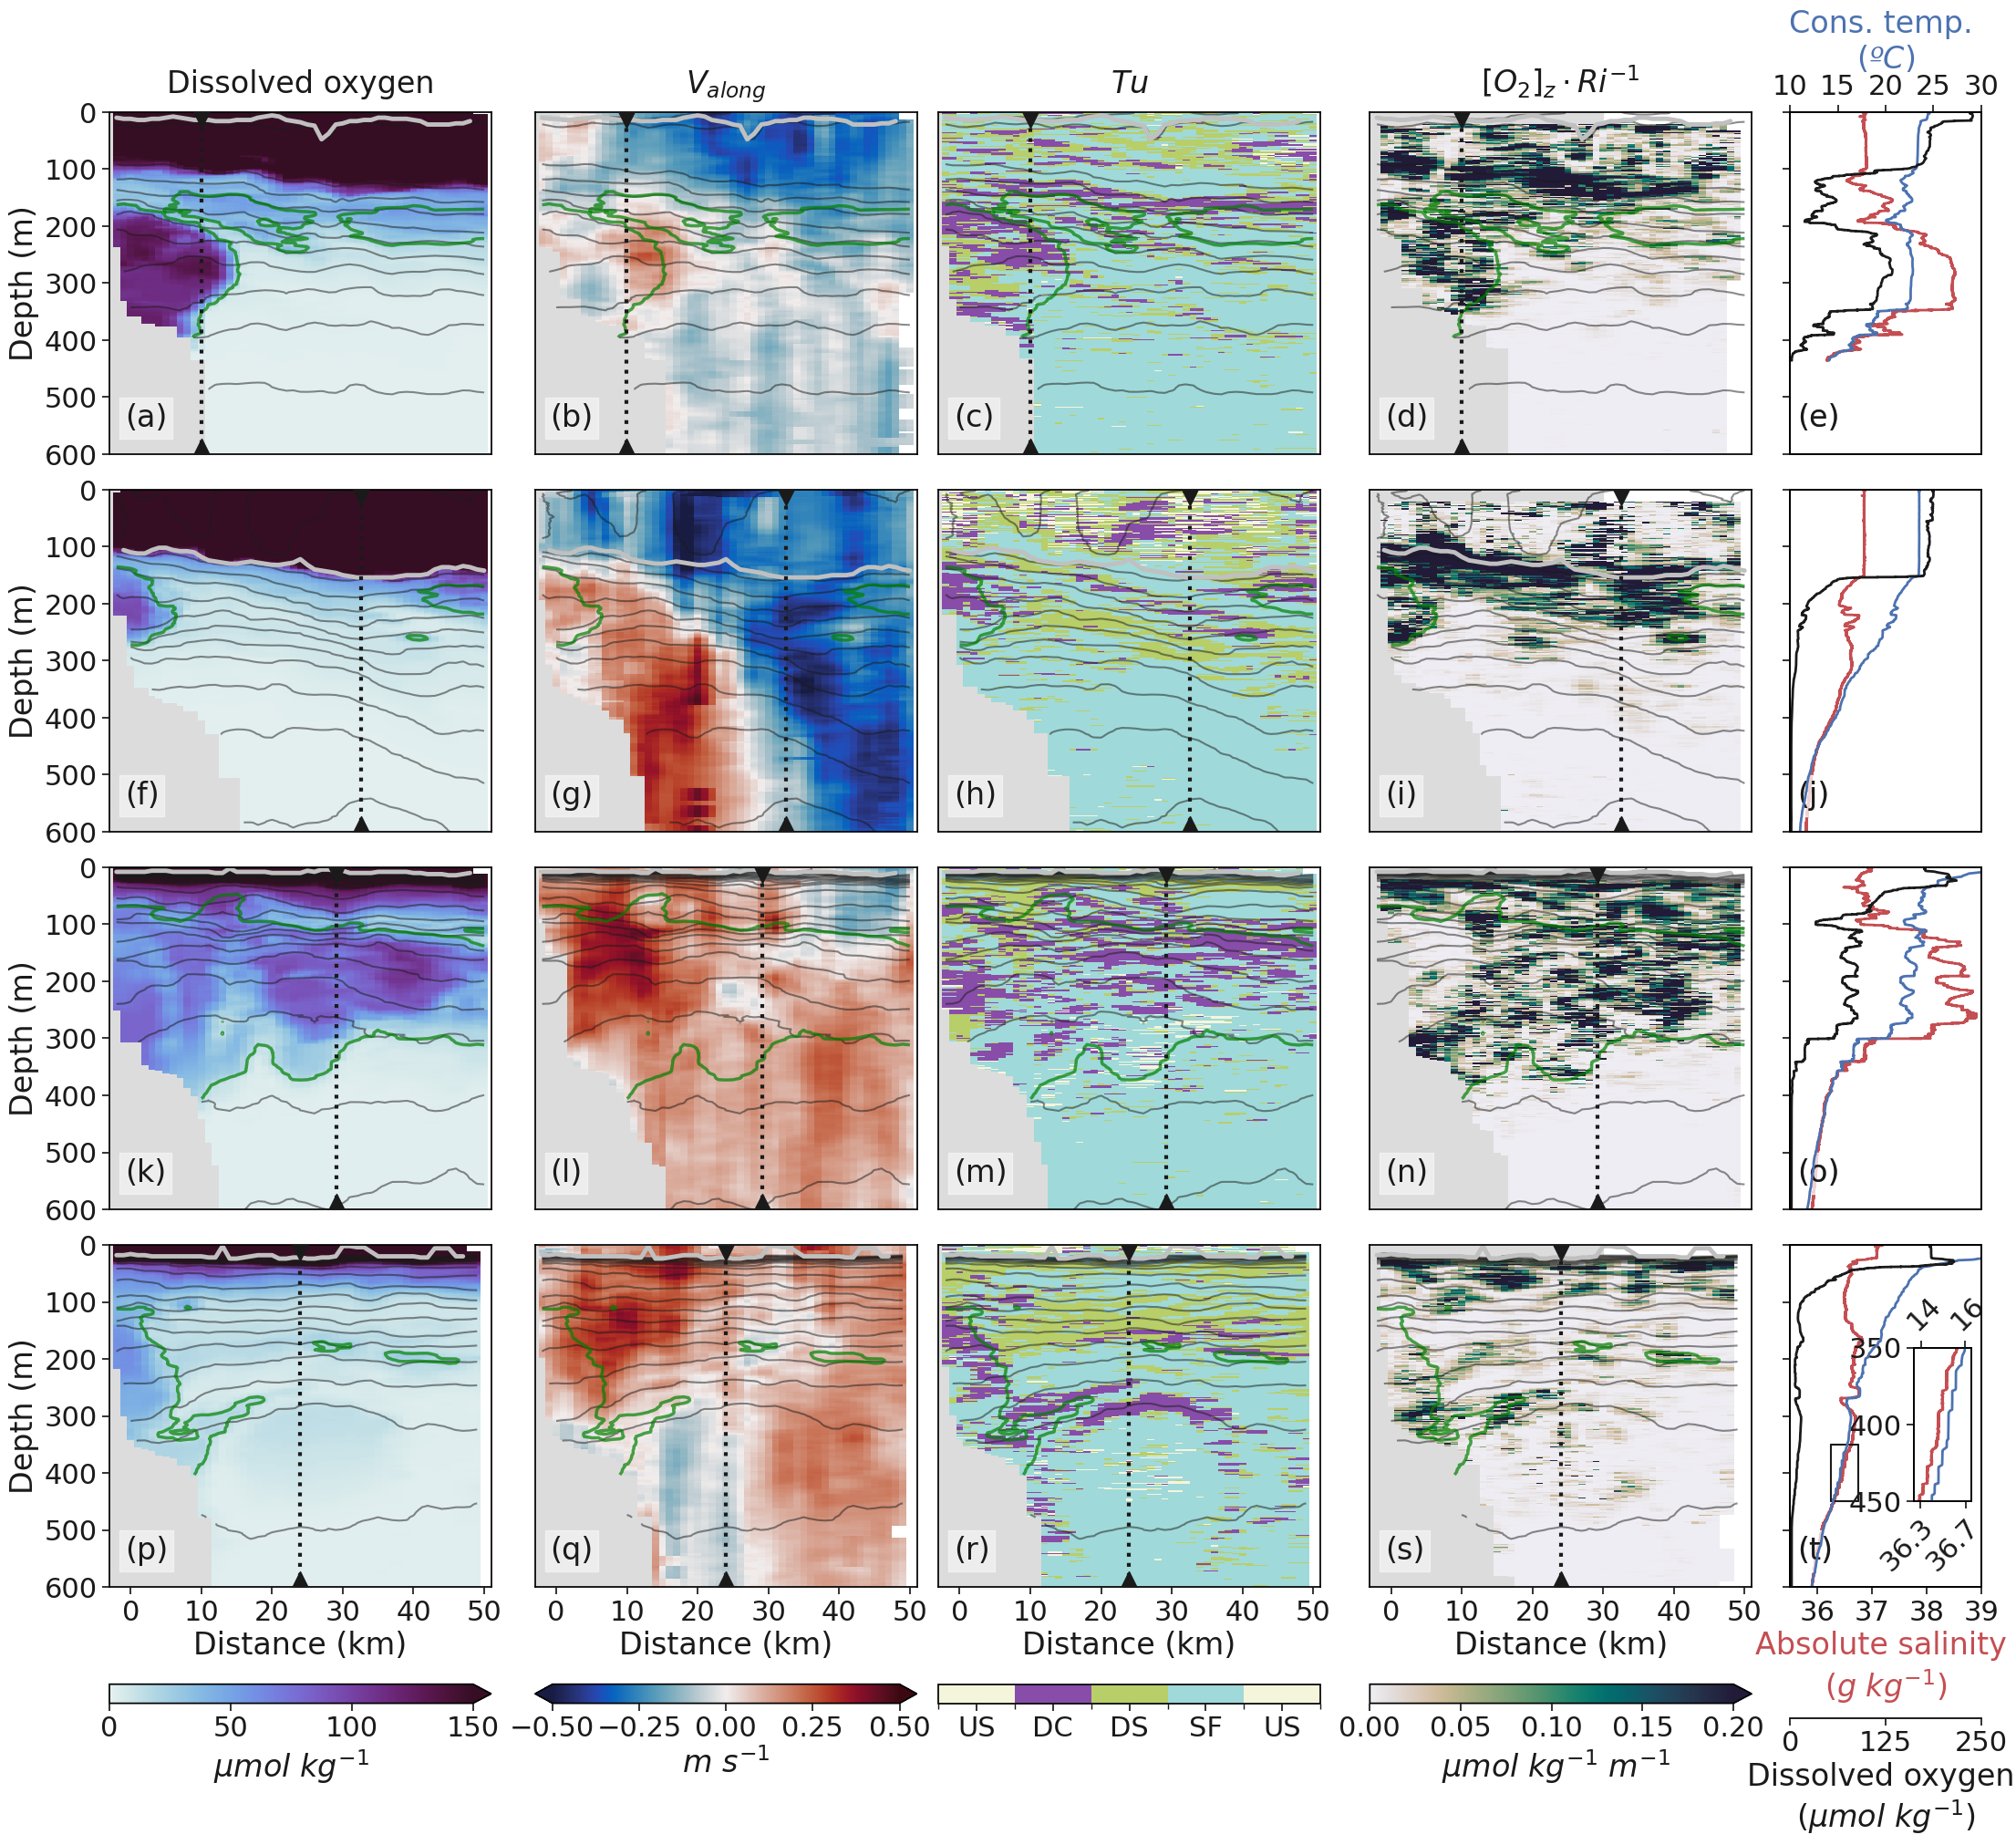

In [11]:
N=[38,31, 55, 69]  ## sections chosen
prf=[28,32, 16,  16]  ## individiual profiles
padN=15
dens_r=0.2
pgw_r=0.2
siz_=600
LWW=2.5
fig, ax=plt.subplots(4, 5,  figsize=(22,20), constrained_layout=True , gridspec_kw={'width_ratios': [2,2,2,2,1]})
alp=0.5
for ind, num in enumerate(N):
    axi=ax[ind, 0]
    axi.axvspan(-10,30,  color="gainsboro")    
    cb=axi.pcolormesh(daxis, yaxis, ds.oxygen_concentration[num],vmin=0, vmax=150, cmap=cmo.dense)
    axi.contour(daxis, yaxis, ds.potential_density[num], levels=np.arange(22,28+dens_r,dens_r), colors='k',  alpha=0.5)
    # axi.contour(daxis, yaxis, ds.pgw_frac[num], levels=np.arange(0,1+pgw_r,pgw_r), colors='green', linewidths=2,alpha=0.7)
    axi.contour(daxis, yaxis, ds.pgw_frac[num], levels=[0.2], colors='green', linewidths=LWW,alpha=0.7)
    
    axi.plot(daxis, ds.mld[num], color='silver', lw=3.5)
    axi.axvline(dist_num_prof(num+1, prf[ind])[0], c='k', ls='dotted', lw=3)
    axi.scatter(dist_num_prof(num+1, prf[ind])[0], 600, marker='^', c='k',s=siz_, zorder=100)
    axi.scatter(dist_num_prof(num+1, prf[ind])[0], 0,marker='v', c='k', s=siz_, zorder=100)
    print('T# '+str(num+1)+'\n' +'P# '+str(dist_num_prof(num+1, prf[ind])[1])+'\n' +pd.Timestamp(ds.time[num].values).strftime("%d %b %Y"))
    axi.set_ylim(600,0)
    axi.set_xlim(-3,51)
    axi.set_xticks([])
    axi.set_yticks([])
    t=axi.text(x=.04,y=.08, s="(" + letters[ind*5] + ')',transform=axi.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    
axiv=plt.colorbar(cb, extend='max', orientation='horizontal', pad=-0.4)
axiv.set_label('$\mu mol$ $kg^{-1}$')
ax[0, 0].set_title('Dissolved oxygen', pad=padN)

for ind, num in enumerate(N):
    axi=ax[ ind, 1]
    axi.axvspan(-10,30,  color="gainsboro")    
    cb=axi.pcolormesh(daxis, yaxis, ds.V_along_detided[num], vmin=-0.5, vmax=0.5, cmap=cmo.balance)
    axi.contour(daxis, yaxis, ds.potential_density[num], levels=np.arange(22,28+dens_r,dens_r), colors='k',  alpha=0.5)
    axi.contour(daxis, yaxis, ds.pgw_frac[num], levels=[0.2], colors='green', linewidths=LWW,alpha=0.7)
    axi.plot(daxis, ds.mld[num], color='silver', lw=3.5)
    axi.axvline(dist_num_prof(num+1, prf[ind])[0], c='k', ls='dotted', lw=3)
    axi.scatter(dist_num_prof(num+1, prf[ind])[0], 600, marker='^', c='k',s=siz_, zorder=100)
    axi.scatter(dist_num_prof(num+1, prf[ind])[0], 0,marker='v', c='k', s=siz_, zorder=100)
    
    t=axi.text(x=.04,y=.08, s="(" + letters[ind*5+1] + ')',transform=axi.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    axi.set_ylim(600,0)
    axi.set_xlim(-3,51)
    axi.set_xticks([])
    axi.set_yticks([])
    

axiv=plt.colorbar(cb, extend='both',orientation='horizontal', pad=-0.4)
axiv.set_label('$m$ $s^{-1}$')
ax[0, 1].set_title('$V_{along}$', pad=padN)

for ind, num in enumerate(N):
    axi=ax[ind, 2]
    axi.axvspan(-10,30,  color="gainsboro")    
    cb=axi.pcolormesh(daxis, yaxis,ds.Tu[num], cmap=cma, norm=norm)
    axi.contour(daxis, yaxis, ds.potential_density[num], levels=np.arange(22,28+dens_r,dens_r), colors='k',  alpha=0.5)
    axi.contour(daxis, yaxis, ds.pgw_frac[num], levels=[0.2], colors='green', linewidths=LWW,alpha=0.7)
    axi.plot(daxis, ds.mld[num], color='silver', lw=3.5)
    axi.axvline(dist_num_prof(num+1, prf[ind])[0], c='k', ls='dotted', lw=3)
    axi.scatter(dist_num_prof(num+1, prf[ind])[0], 600, marker='^', c='k',s=siz_, zorder=100)
    axi.scatter(dist_num_prof(num+1, prf[ind])[0], 0,marker='v', c='k', s=siz_, zorder=100)
    t=axi.text(x=.04,y=.08, s="(" + letters[ind*5+2] + ')',transform=axi.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    axi.set_ylim(600,0)
    axi.set_xlim(-3,51)
    axi.set_yticks([])
    axi.set_xticks([])
axiv=plt.colorbar(cb,  orientation='horizontal', ticks=[-135,-67.5,-0,67.5,135], pad=-0.4)
axiv.ax.set_xticklabels(['US', 'DC', 'DS', 'SF', 'US'])
# axiv.set_label('$Tu$')
ax[0, 2].set_title('$Tu$', pad=padN)


for ind, num in enumerate(N):
    axi=ax[ind, 4]
    ax1, ax2, ax3=plot_profiles_oxy(axi, num+1, prf[ind])
    axi.set_yticklabels([])   
    t=axi.text(x=.04,y=.08, s="(" + letters[ind*5+4] + ')',transform=axi.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    
    ax2.set_xticks([10,15,20,25,30])   
    ax1.set_xticks([36,37,38,39])   
    ax3.set_xticks(np.arange(0,250+125,125))
    if ind ==0:
        ax1.set_xticklabels([])
        ax3.set_xticklabels([])
        ax1.set_xticks([])
        ax3.set_xticks([])
        
        ax2.set_xlabel('Cons. temp. \n($ºC$)')
        ax2.xaxis.label.set_color('b')  
        ax2.xaxis.set_ticks_position("top")
        ax2.xaxis.set_label_position("top")

    elif ind ==3:
        ax2.set_xticklabels([])
        ax2.set_xticks([])
        ax1.set_xlabel('Absolute salinity \n($g$ $kg^{-1}$)')
        ax1.xaxis.label.set_color('r')
        ax3.set_xlabel('Dissolved oxygen \n($\mu mol$ $kg^{-1}$)')
        ax3.xaxis.label.set_color('k')
        ax3.xaxis.set_ticks_position("bottom")
        ax3.xaxis.set_label_position("bottom")
        ax3.spines.bottom.set_position(('data', 830))
        tmin,tmax, dmin, dmax=36.25,36.75, 350,450
        ax1.plot([tmin, tmin], [dmin, dmax], c='k')
        ax1.plot([tmax, tmax], [dmin, dmax], c='k')
        ax1.plot([tmin, tmax], [dmin, dmin], c='k')
        ax1.plot([tmin, tmax],[dmax, dmax], c='k')
        
        inset_ax = axi.inset_axes([.65, .25, .3, .45])
        ax1, ax2=plot_profiles(inset_ax, num+1, prf[ind])
        ax1.set_xlim([36.25,36.75])
        ax2.set_xlim([13.7,16.3])
        ax2.set_xticks([14,16])
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
        ax1.set_ylim([450, 350])
        ax1.set_xticks([36.3, 36.7])
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        
    else:
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])
        ax3.set_xticklabels([])
        ax1.set_xticks([])
        ax3.set_xticks([])
        ax2.set_xticks([])
        
        
for ind, num in enumerate(N):
    axi=ax[ind, 4] 
    t=axi.text(x=.04,y=.08, s="(" + letters[ind*5+4] + ')',transform=axi.transAxes, zorder=200)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    

    
for ind, num in enumerate(N):
    axi=ax[ ind, 3]
    axi.axvspan(-10,30,  color="gainsboro")    
    cb=axi.pcolormesh(daxis, yaxis, ds['O2_Ri'][num], cmap=cmo.rain, vmin=0, vmax=0.2)
    axi.contour(daxis, yaxis, ds.potential_density[num], levels=np.arange(22,28+dens_r,dens_r), colors='k',  alpha=0.5)
    axi.contour(daxis, yaxis, ds.pgw_frac[num], levels=[0.2], colors='green', linewidths=LWW,alpha=0.7)
    axi.plot(daxis, ds.mld[num], color='silver', lw=3.5)
    axi.axvline(dist_num_prof(num+1, prf[ind])[0], c='k', ls='dotted', lw=3)
    axi.scatter(dist_num_prof(num+1, prf[ind])[0], 600, marker='^', c='k',s=siz_, zorder=100)
    axi.scatter(dist_num_prof(num+1, prf[ind])[0], 0,marker='v', c='k', s=siz_, zorder=100)
    t=axi.text(x=.04,y=.08,s="(" + letters[ind*5+3] + ')',transform=axi.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    axi.set_ylim(600,0)
    axi.set_xlim(-3,51)
    axi.set_xticks([])
    axi.set_yticks([])
axiv=plt.colorbar(cb, extend='max', orientation='horizontal', pad=-0.4)
axiv.set_label(' $\mu mol$ $kg^{-1}$ $m^{-1}$')   
ax[0, 3].set_title('$[O_2]_z \cdot Ri^{-1}$', pad=padN)

for i in range(4):
    ax[i, 0].set_ylabel('Depth (m)')
    ax[i, 0].set_yticks(np.arange(0,700,100))
    ax[3, i].set_xlabel('Distance (km)')
    ax[3, i].set_xticks(np.arange(0,60,10))
    
plt.savefig('Figure_8.png', dpi=600)